In [3]:
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import optuna
#from optuna.samplers import TPESampler
import time
import pandas as pd
from sklearn.metrics import accuracy_score

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.0 MB/s eta 0:00:00


In [2]:
df = pd.read_csv("/Users/pmalykh/PycharmProjects/texts_attribution/Данные/dataset.csv")

NameError: name 'pd' is not defined

In [9]:
don = pd.read_csv("/content/don.csv")

In [8]:
df.rename(columns={prev_name: prev_name.split()[1] for prev_name in df.columns[:-1]}, inplace=True)

In [10]:
don.rename(columns={prev_name: prev_name.split()[1] for prev_name in don.columns[:-1]}, inplace=True)

In [96]:
don.drop(columns="ones_to_zeros", inplace=True)

In [97]:
don.drop(columns="most_common_first_letter_in_sentences", inplace=True)

In [98]:
df.drop(columns="ones_to_zeros", inplace=True)

In [99]:
df.drop(columns="most_common_first_letter_in_sentences", inplace=True)

In [10]:
def cross_val(df, model):
    accuracy = []
    train_last, test_last = 0, 0
    for shift in range(0, 10, 2):
            authors_seen = []
            test_ixs = []
            for ixs in range(len(df)):
                aut = df['targets'][ixs]
                if authors_seen.count(aut) < 2:
                    authors_seen += [aut]
                    test_ixs += [ixs + shift]
            train_ixs = list(set(range(len(df))) - set(test_ixs))
            if shift != 8:
                y_test = df.iloc[test_ixs]['targets']
                x_test = df.iloc[test_ixs].drop(columns=["targets"])
                y_train = df.iloc[train_ixs]['targets']
                x_train = df.iloc[train_ixs].drop(columns=["targets"])

                rfc = model
                rfc.fit(x_train, y_train)
                accuracy.append(accuracy_score(y_test, rfc.predict(x_test)))
            else:
                train_last = train_ixs
                test_last = test_ixs

    return pd.Series(accuracy), train_last, test_last

In [11]:
from sklearn.base import clone

from copy import deepcopy

def validation(df, model):
    accuracy = []
    models = []
    for shift in range(0, 10, 2):
        authors_seen = []
        test_ixs = []
        for ixs in range(len(df)):
            aut = df['targets'][ixs]
            if authors_seen.count(aut) < 2:
                authors_seen += [aut]
                test_ixs += [ixs + shift]
        train_ixs = list(set(range(len(df))) - set(test_ixs))
        y_test = df.iloc[test_ixs]['targets']
        x_test = df.iloc[test_ixs].drop(columns=["targets"])
        y_train = df.iloc[train_ixs]['targets']
        x_train = df.iloc[train_ixs].drop(columns=["targets"])

        rfc = model
        rfc.fit(x_train, y_train)
        accuracy.append(accuracy_score(y_test, rfc.predict(x_test)))
        models.append(deepcopy(rfc))
    return models, pd.Series(accuracy)

In [ ]:
def objective(trial):
    cbc = CatBoostClassifier(
        task_type="GPU",
        devices='0:1',
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        verbose=False
    )
    vals, train_ixs, test_ixs = cross_val(df, cbc)
    return vals.mean()

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="targets"), df["targets"], stratify=df["targets"], random_state=42)

In [4]:
cbc = CatBoostClassifier(task_type="CPU",
                           devices='0:1', verbose=1)
#feature_names = [f"feature {i}" for i in range(df.drop(columns="targets").shape[1])]
#cbc.fit(X_train, y_train)
#predicts = validation(df, cbc)
#predicts, predicts.mean()


In [86]:
accuracy_score(cbc.predict(X_test), y_test)

0.6201550387596899

In [ ]:
etc = ExtraTreesClassifier()
val = validation(df, cbc)
models, metrics = val[0], val[1]
metrics.mean()

In [ ]:
metrics

In [19]:
models

In [20]:
for model in models:
  print(model.predict(don.drop(columns="targets")).tolist())

[['А. Н. Толстой'], ['М. А. Шолохов'], ['Ф. Д. Крюков'], ['М. А. Шолохов']]
[['Ф. Д. Крюков'], ['М. А. Шолохов'], ['М. А. Шолохов'], ['М. А. Шолохов']]
[['Ф. Д. Крюков'], ['М. А. Шолохов'], ['М. А. Шолохов'], ['М. А. Шолохов']]
[['А. Н. Толстой'], ['М. А. Шолохов'], ['М. А. Шолохов'], ['М. А. Шолохов']]
[['А. Н. Толстой'], ['М. А. Шолохов'], ['М. А. Шолохов'], ['М. А. Шолохов']]


In [15]:
etc.fit(df.drop(columns="targets"), df["targets"])

ExtraTreesClassifier()

In [5]:
cbc.fit(df.drop(columns="targets"), df["targets"])

Learning rate set to 0.076501
0:	learn: 3.8706942	total: 170ms	remaining: 2m 50s
1:	learn: 3.8355856	total: 273ms	remaining: 2m 16s
2:	learn: 3.7966055	total: 393ms	remaining: 2m 10s
3:	learn: 3.7676368	total: 502ms	remaining: 2m 5s
4:	learn: 3.7338912	total: 605ms	remaining: 2m
5:	learn: 3.6886763	total: 718ms	remaining: 1m 58s
6:	learn: 3.6477815	total: 820ms	remaining: 1m 56s
7:	learn: 3.6092422	total: 919ms	remaining: 1m 53s
8:	learn: 3.5772189	total: 1.04s	remaining: 1m 54s
9:	learn: 3.5408122	total: 1.14s	remaining: 1m 53s
10:	learn: 3.5025422	total: 1.25s	remaining: 1m 52s
11:	learn: 3.4656889	total: 1.38s	remaining: 1m 53s
12:	learn: 3.4287660	total: 1.48s	remaining: 1m 52s
13:	learn: 3.3975173	total: 1.58s	remaining: 1m 51s
14:	learn: 3.3574785	total: 1.71s	remaining: 1m 52s
15:	learn: 3.3259151	total: 1.83s	remaining: 1m 52s
16:	learn: 3.2894231	total: 1.95s	remaining: 1m 52s
17:	learn: 3.2574832	total: 2.08s	remaining: 1m 53s
18:	learn: 3.2236600	total: 2.22s	remaining: 1m 5

In [16]:
etc.predict(don.drop(columns="targets"))

array(['А. Н. Толстой', 'А. Н. Толстой', 'М. А. Шолохов', 'А. Н. Толстой'],
      dtype=object)

In [22]:
cbc.predict(don.drop(columns="targets"))

array([['А. Н. Толстой'],
       ['М. А. Шолохов'],
       ['М. А. Шолохов'],
       ['М. А. Шолохов']], dtype=object)

In [89]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    cbc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

cbc_importances = pd.Series(result.importances_mean[:20], index=feature_names[:20])

Elapsed time to compute the importances: 7.516 seconds


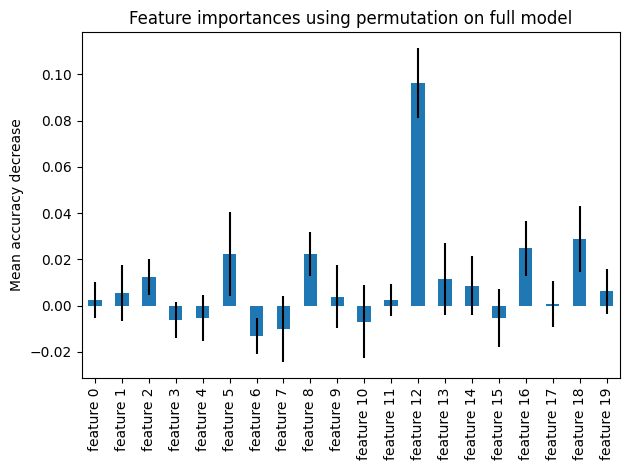

In [91]:
fig, ax = plt.subplots()
cbc_importances.plot.bar(yerr=result.importances_std[:20], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

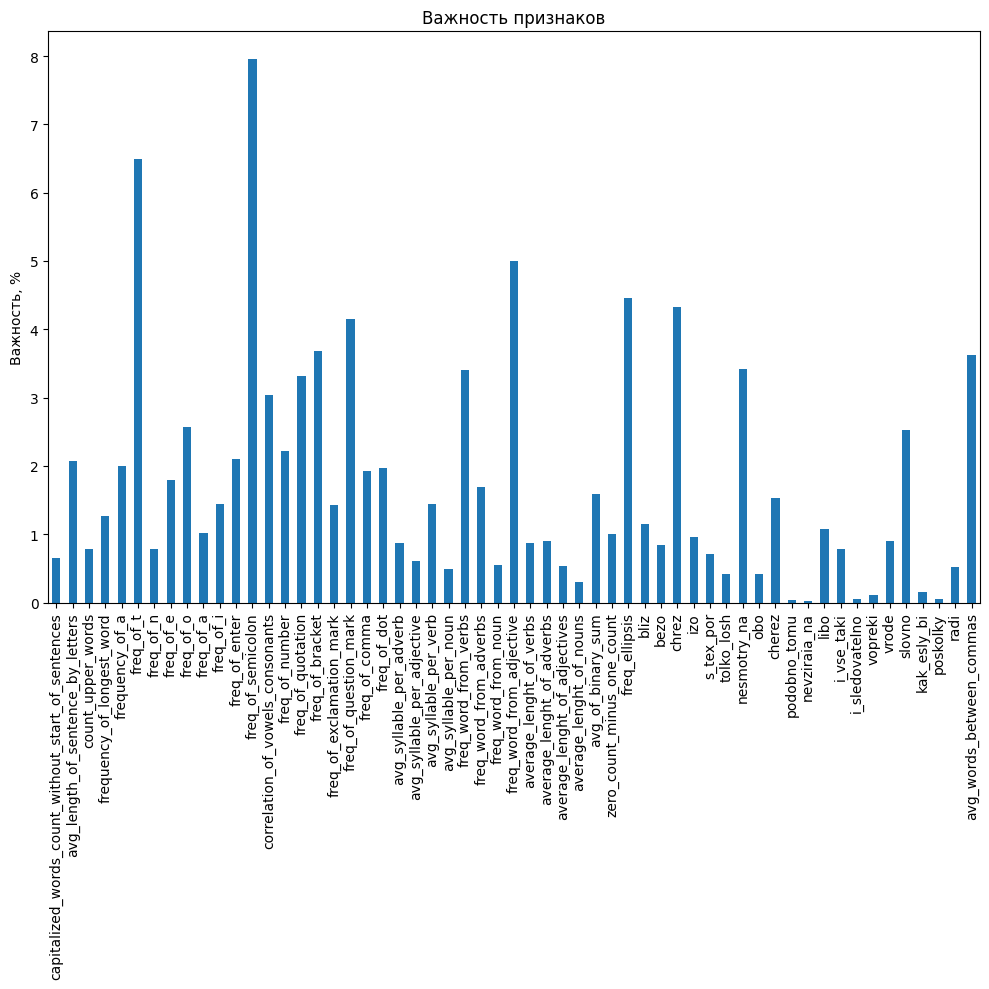

In [25]:
cat_iris_imp = pd.Series(cbc.get_feature_importance(),
                         df.drop(['targets'], axis=1).columns)
fig, ax = plt.subplots(figsize=(10,10))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [1]:
import plotly.express as px

fig = px.imshow(df.drop(columns=["targets"]).corr(), text_auto=True)
fig.update_layout(height=1000)
fig.show()

NameError: name 'df' is not defined